# Imports

In [34]:
"""
lecture/video 60
"""
import torch
import numpy as np
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt

torch.__version__

'1.13.1'

# Device agnostic code

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [36]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
print(X[:5])
print(y[:5])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])


# Split data into train and test data

In [37]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
print('training data')
print(X_train.shape, y_train.shape)
print('testing data')
print(X_test.shape, y_test.shape)

training data
torch.Size([40, 1]) torch.Size([40, 1])
testing data
torch.Size([10, 1]) torch.Size([10, 1])


In [38]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})
    plt.show()

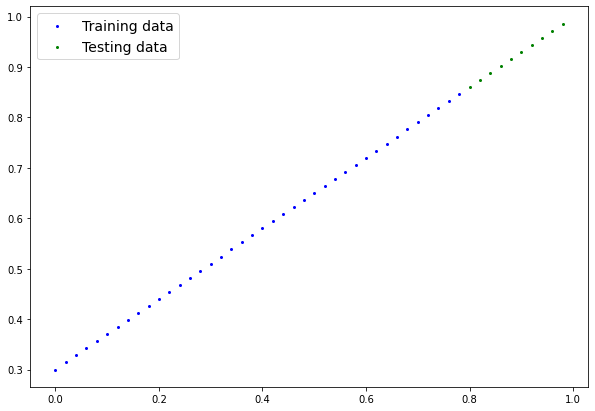

In [39]:
plot_predictions()

# Define model

In [40]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [41]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
print(model_1)
print(model_1.state_dict())

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


# Training

In [42]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [43]:
device

'cpu'

Epoch: 0 | loss: 0.5551779866218567 | test_loss: 0.5739762187004089
Epoch: 10 | loss: 0.4399680495262146 | test_loss: 0.4392663538455963
Epoch: 20 | loss: 0.3247582018375397 | test_loss: 0.30455657839775085
Epoch: 30 | loss: 0.20954827964305878 | test_loss: 0.16984674334526062
Epoch: 40 | loss: 0.09433844685554504 | test_loss: 0.03513689711689949
Epoch: 50 | loss: 0.023886386305093765 | test_loss: 0.04784906655550003
Epoch: 60 | loss: 0.0199567973613739 | test_loss: 0.04580312222242355
Epoch: 70 | loss: 0.016517987474799156 | test_loss: 0.0375305712223053
Epoch: 80 | loss: 0.013089170679450035 | test_loss: 0.029944902285933495
Epoch: 90 | loss: 0.009653178043663502 | test_loss: 0.02167237363755703


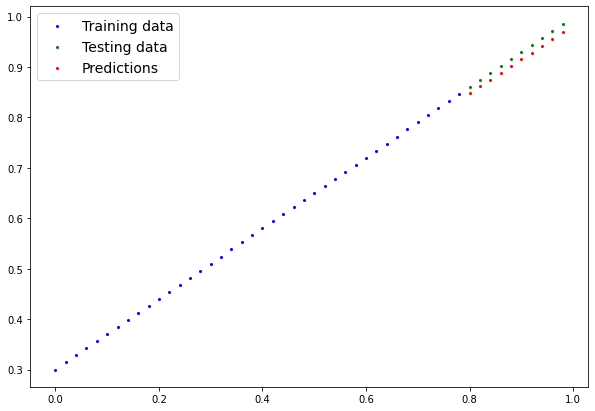

In [44]:
torch.manual_seed(42)
epochs = 100
epoch_counter = []
losses = []
test_losses = []

# put data on target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # set to training mode
    model_1.train()

    # 1. make the predictions (forward pass)
    y_pred = model_1(X_train)

    # 2. compute the error amount (loss)
    loss = loss_fn(y_pred, y_train)

    # 3. clear the gradients so it doesn't accumulate
    optimizer.zero_grad()

    # 4. compute the gradients (backpropagation)
    loss.backward()

    # 5. update the parameters (gradient descent)
    optimizer.step()

    ### TEST ###
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_counter.append(epoch)
        losses.append(loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch} | loss: {loss} | test_loss: {test_loss}")

# try out the new model
with torch.inference_mode():
    preds = model_1(X_test)
plot_predictions(predictions=preds)

In [45]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

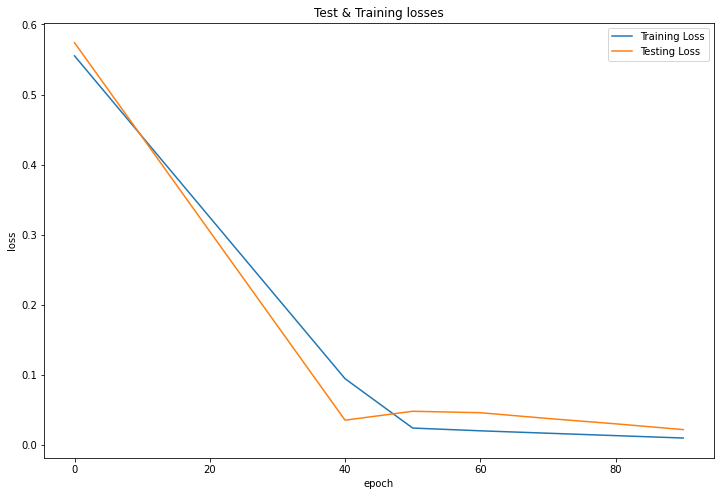

In [46]:
plt.plot(epoch_counter, np.array(torch.tensor(losses).numpy()), label="Training Loss")
plt.plot(epoch_counter, test_losses, label="Testing Loss")
plt.title("Test & Training losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.gcf().set_size_inches(12, 8)
plt.show()

# Save the model

In [48]:
# create the models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create the model save path
model_name = [name for name in globals() if globals()[name] is model_1][0]
MODEL_NAME = f"pytorch_linear_regression_{model_name}.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f"\n_> Saving model to {MODEL_SAVE_PATH} ✅\n")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)


_> Saving model to models/pytorch_linear_regression_model_1.pth ✅



# Load the model

In [51]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

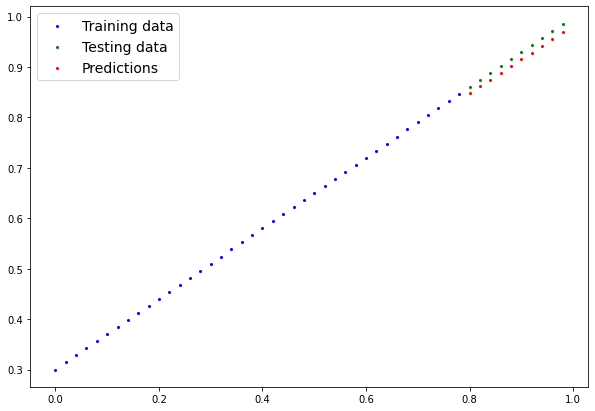

In [52]:
with torch.inference_mode():
    loaded_preds = loaded_model_1(X_test)

plot_predictions(predictions=loaded_preds)